# Question 1

In [3]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func:{f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed

@timeit
def sleep(sec):
    return time.sleep(sec)

sleep(0.1)

func:sleep took: 0.1026 sec


In [2]:
def load_dataset(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)
    
    X_train = torch.tensor(train_data[0], dtype=torch.float)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test

In [3]:
class MnistDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        if not isinstance(X, torch.Tensor):
            self.X = torch.tensor(X, dtype=torch.float)
        else:
            self.X = X
        
        if not isinstance(y, torch.Tensor):
            self.y = torch.tensor(y, dtype=torch.long)
        else:
            self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


## (a)

In [4]:
X_train, y_train, X_test, y_test = load_dataset('/Users/mac_1/Desktop/CHEM C142/mnist.pkl')
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()
y_train = (y_train/y_test.max()).long()
y_test = (y_test/y_test.max()).long()

In [5]:
torch.cuda.is_available()

False

## (b)

**Complete the following Python class for training/evaluation**

In [6]:
class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        if opt_method == "adam":
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    @timeit
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=False):
            # enable train mode
            self.model.train()
            for X_batch, y_batch in train_loader:
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

            train_loss, train_acc = self.evaluate(train_data)
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            
            val_loss, val_acc = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        # enable evaluation mode
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=False)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = X_batch.size(0)
                y_pred = self.model(X_batch)
                y_batch = y_batch.long()
                batch_loss = loss_func(y_pred, y_batch)
                _, predicted_labels = torch.max(y_pred, 1)
                batch_acc = (predicted_labels == y_batch).float().mean()
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc
            
            

**Complete the following function to do KFold cross validation**

In [7]:
def KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0
):
    test_data = MnistDataset(X_test, y_test)
    kf = KFold(n_splits=k, shuffle=True, random_state=None)

    train_acc_list, test_acc_list = [], []
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"Fold {i}:")
        
        # Use MnistDataset to organize data
        train_data = MnistDataset(X_train[train_index], y_train[train_index])
        val_data = MnistDataset(X_train[val_index], y_train[val_index])

        
        model = model_class()
        # initialize a Trainer object
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2)
        # call trainer.train() here
        res = trainer.train(train_data, val_data)
        train_acc_best = res['train_acc_list'][np.argmin(res['val_loss_list'])]
        test_loss, test_acc = trainer.evaluate(test_data)
        
        train_acc_list.append(train_acc_best)
        test_acc_list.append(test_acc)
        
        print(f"Training accuracy: {train_acc_best}")
        print(f"Test accuracy: {test_acc}")
    
    print("Final results:")
    print(f"Training accuracy: {np.mean(train_acc_list)}+/-{np.std(train_acc_list)}")
    print(f"Test accuracy: {np.mean(test_acc_list)}+/-{np.std(test_acc_list)}")

## (c)

In [8]:
class Net3(nn.Module):
    def __init__(self, input_size=1024):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 3)
        
        # Define the second (output) layer with 10 neurons (for 10 classes)
        self.fc2 = nn.Linear(3, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        # Apply the first layer with sigmoid activation
        x = torch.sigmoid(self.fc1(x))
        
        # Apply the second layer. The raw output is returned since
        # nn.CrossEntropyLoss will apply softmax internally
        x = self.fc2(x)
        return x

Fold 0:
Net3 - Number of parameters: 3115


func:train took: 36.0385 sec
Training accuracy: 39371.0
Test accuracy: 9827.0
Fold 1:
Net3 - Number of parameters: 3115


func:train took: 36.8843 sec
Training accuracy: 39547.0
Test accuracy: 9827.0
Fold 2:
Net3 - Number of parameters: 3115


func:train took: 36.9684 sec
Training accuracy: 39410.0
Test accuracy: 9807.0
Final results:
Training accuracy: 39442.666666666664+/-75.47332126137171
Test accuracy: 9820.333333333334+/-9.428090415820632


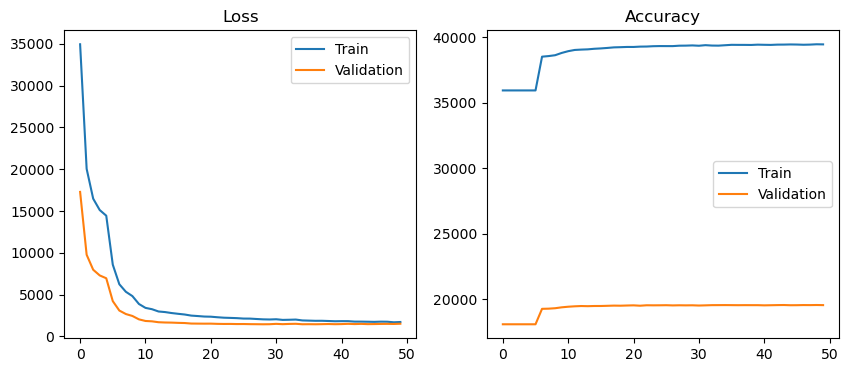

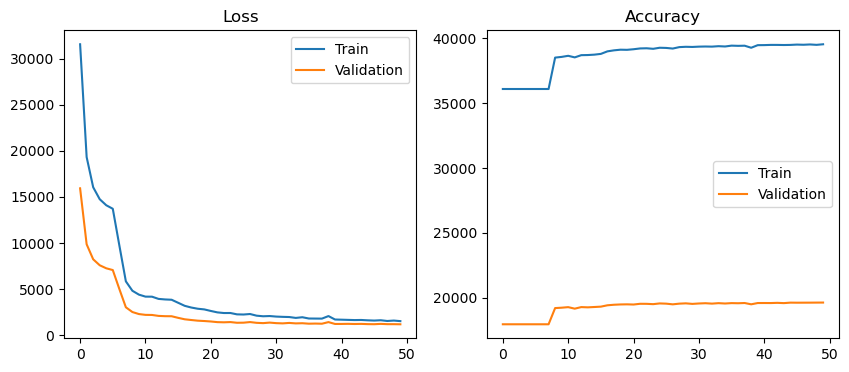

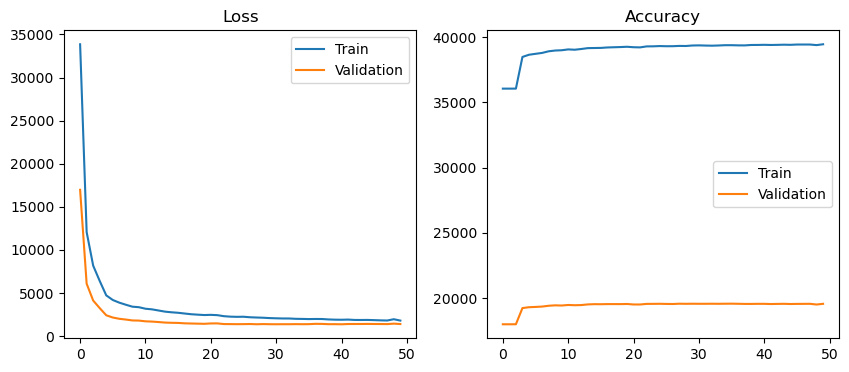

In [9]:
KFoldCrossValidation(Net3, 3,X_train, y_train, X_test, y_test)

Thee model appears to strike a good balance between bias and variance, indicating that it can effectively learn from the training data without overfitting and generalize well to new, unseen data. This suggests that the model is appropriately suited for the task at hand.

## (d)

In [10]:
class Net50(nn.Module):
    def __init__(self, input_size=1024):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 50)  # Hidden layer with 50 neurons
        self.fc2 = nn.Linear(50, 10)          # Output layer with 10 neurons (for 10 classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)            # Flatten the input
        x = torch.relu(self.fc1(x))          # Apply ReLU activation to the hidden layer
        x = self.fc2(x)                      # Output layer (no activation function applied)
        return x


Fold 0:
Net50 - Number of parameters: 51760


func:train took: 44.5581 sec
Training accuracy: 39733.0
Test accuracy: 9916.0
Fold 1:
Net50 - Number of parameters: 51760


func:train took: 43.4099 sec
Training accuracy: 39813.0
Test accuracy: 9914.0
Fold 2:
Net50 - Number of parameters: 51760


func:train took: 43.9478 sec
Training accuracy: 39741.0
Test accuracy: 9906.0
Final results:
Training accuracy: 39762.333333333336+/-35.97530016861877
Test accuracy: 9912.0+/-4.320493798938574


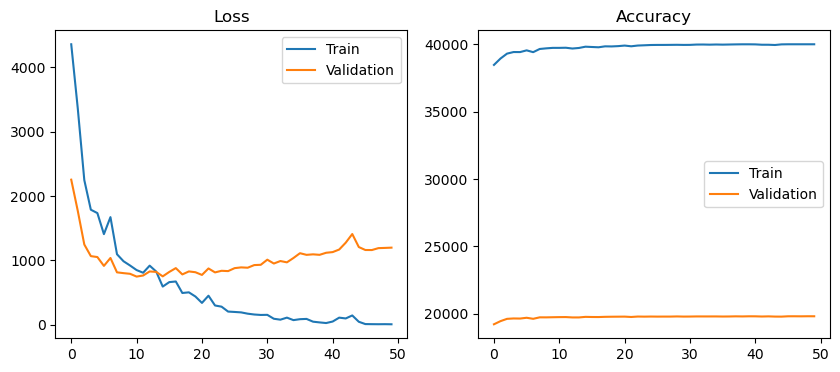

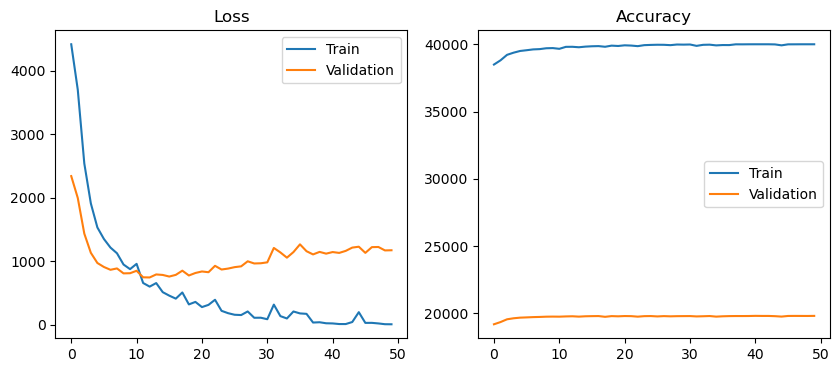

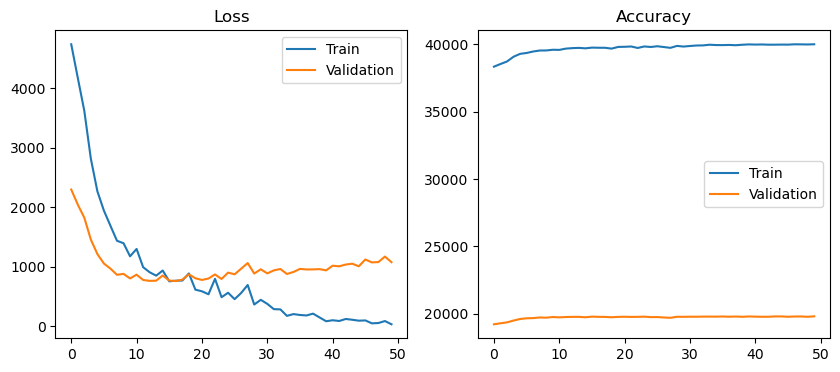

In [11]:
KFoldCrossValidation(Net50, 3,X_train, y_train, X_test, y_test)

Although the model shows quit ehigh accuracy for both test and validation, there was an increase in loss function of validation curve as epoch increases which indicates a potential overfitting.






# Question 2

## (a)

In [12]:
class Net50Dropout(nn.Module):
    def __init__(self, input_size=1024,dropout_rate=0.15):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 50)  # Hidden layer with 50 neurons
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer with dropout_rate
        self.fc2 = nn.Linear(50, 10)          # Output layer with 10 neurons (for 10 classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)            # Flatten the input
        x = torch.relu(self.fc1(x))          # Apply ReLU activation to the hidden layer
        x = self.dropout(x)                  # Apply dropout
        x = self.fc2(x)                      # Output layer (no activation function applied)
        return x

Fold 0:
Net50Dropout - Number of parameters: 51760


func:train took: 46.8323 sec
Training accuracy: 39807.0
Test accuracy: 9906.0
Fold 1:
Net50Dropout - Number of parameters: 51760


func:train took: 44.6059 sec
Training accuracy: 39852.0
Test accuracy: 9910.0
Fold 2:
Net50Dropout - Number of parameters: 51760


func:train took: 45.0488 sec
Training accuracy: 39843.0
Test accuracy: 9914.0
Final results:
Training accuracy: 39834.0+/-19.44222209522358
Test accuracy: 9910.0+/-3.265986323710904


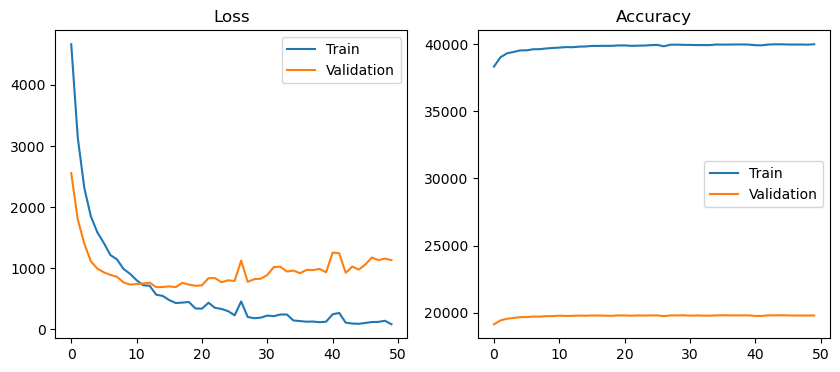

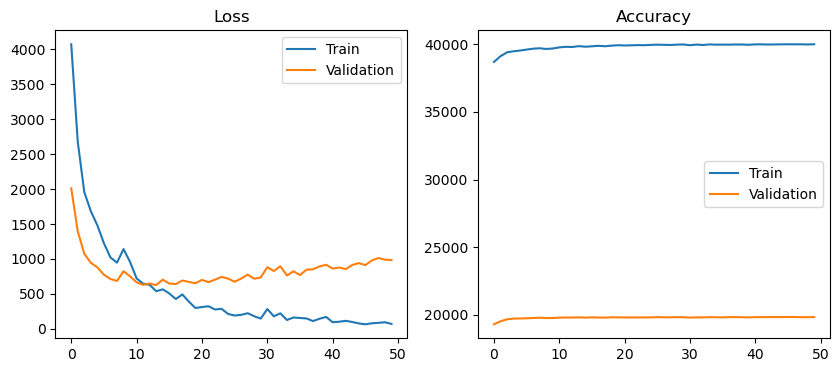

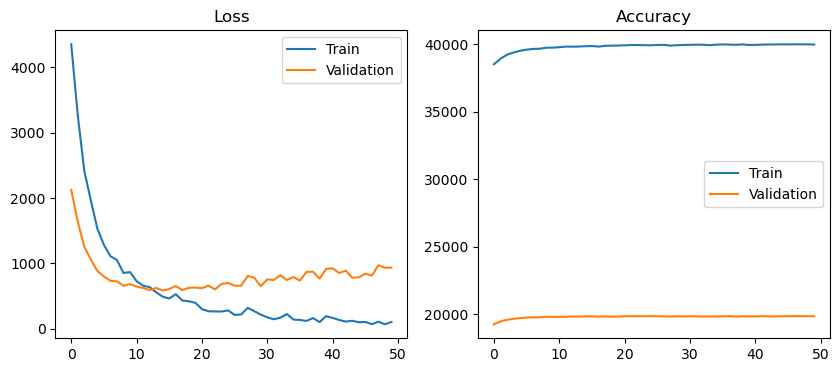

In [13]:
KFoldCrossValidation(Net50Dropout, 3,X_train, y_train, X_test, y_test)

There was an increase in both tranning and testing accuracy. Droput regularization technique effectively prevents overfitting.

## (b)

Fold 0:
Net50 - Number of parameters: 51760


func:train took: 56.8819 sec
Training accuracy: 39882.0
Test accuracy: 9918.0
Fold 1:
Net50 - Number of parameters: 51760


func:train took: 57.5040 sec
Training accuracy: 39841.0
Test accuracy: 9916.0
Fold 2:
Net50 - Number of parameters: 51760


func:train took: 56.2084 sec
Training accuracy: 39886.0
Test accuracy: 9918.0
Final results:
Training accuracy: 39869.666666666664+/-20.33606539022619
Test accuracy: 9917.333333333334+/-0.9428090415820634


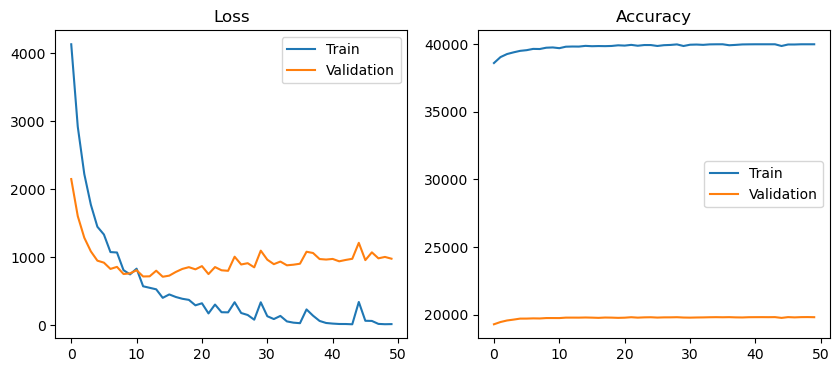

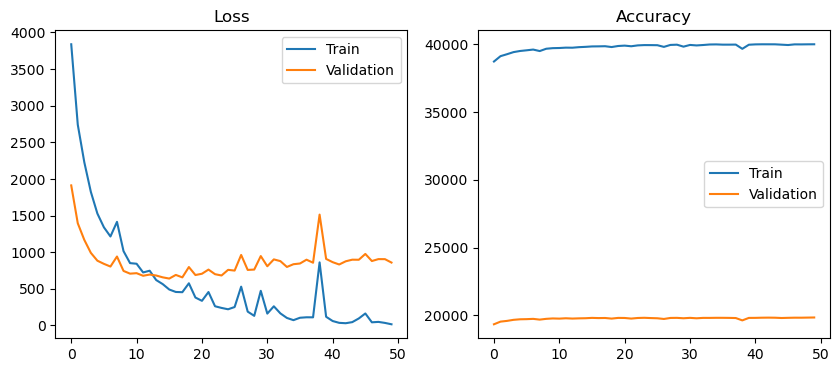

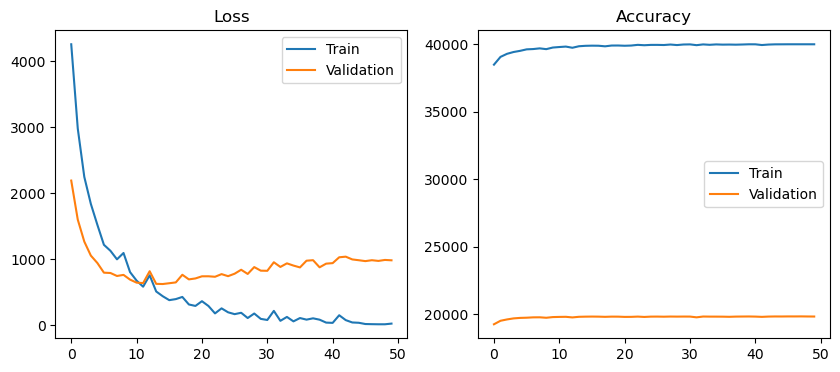

In [14]:
# L2 Regularizaiton by setting the "l2" parameter in KFoldCrossValidation
KFoldCrossValidation(Net50, 3,X_train, y_train, X_test, y_test, l2 = 1e-5)

There was an increase in both Tranning and testing accuracy. L2 regularization technique effectively prevents overfitting.

## (c)

*For debugging*: You should get 331 features.

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99) 

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# fit
pca.fit(X_train)
# transform
X_train_pca = torch.tensor(pca.transform(X_train),dtype = torch.float)
X_test_pca = torch.tensor(pca.transform(X_test), dtype = torch.float)
print(X_train_pca.shape, X_test_pca.shape)

torch.Size([60000, 331]) torch.Size([10000, 331])


In [17]:
# Use one hidden layer of size 50, no Dropouts
class Net50PCA(nn.Module):
    def __init__(self, num_features =331):
        super(Net50PCA, self).__init__()
        self.fc1 = nn.Linear(num_features, 50)  # One hidden layer of size 50
        self.fc2 = nn.Linear(50, 10)            # Output layer with 10 neurons (for 10 classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the hidden layer
        x = self.fc2(x)              # Output layer (no activation function applied)
        return x

Fold 0:
Net50PCA - Number of parameters: 17110


func:train took: 39.5840 sec
Training accuracy: 39993.0
Test accuracy: 9909.0
Fold 1:
Net50PCA - Number of parameters: 17110


func:train took: 39.2898 sec
Training accuracy: 39949.0
Test accuracy: 9906.0
Fold 2:
Net50PCA - Number of parameters: 17110


func:train took: 40.1397 sec
Training accuracy: 39951.0
Test accuracy: 9913.0
Final results:
Training accuracy: 39964.333333333336+/-20.28683207293725
Test accuracy: 9909.333333333334+/-2.8674417556808756


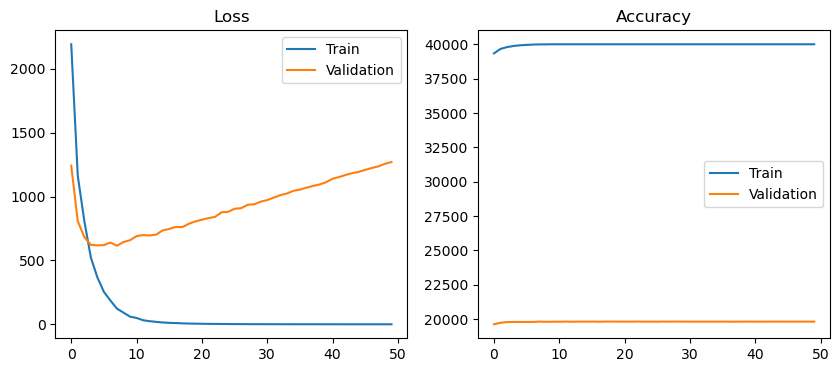

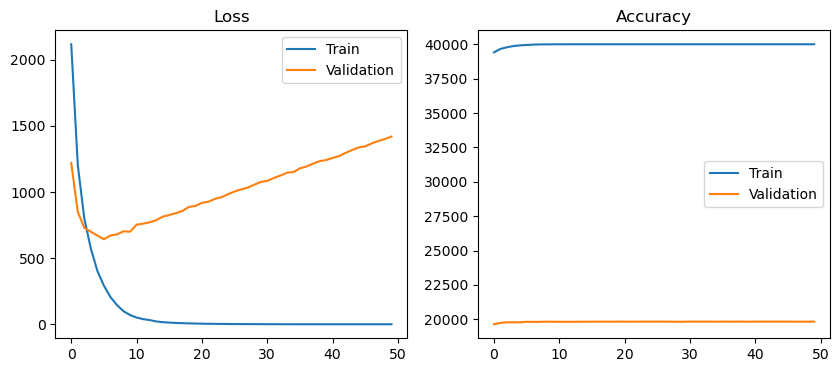

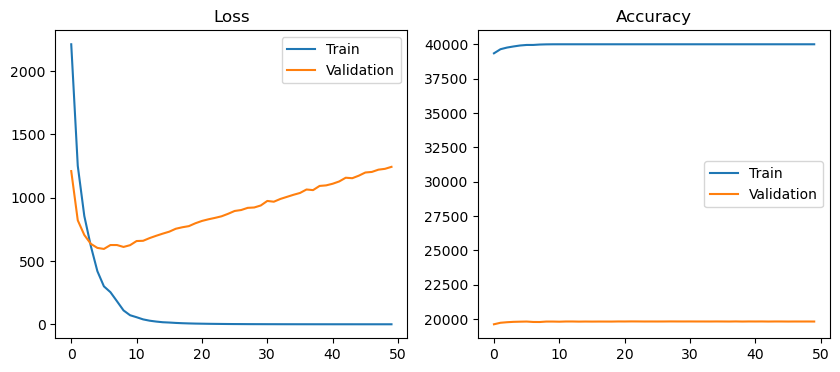

In [18]:
KFoldCrossValidation(Net50PCA, 3,X_train_pca, y_train, X_test_pca, y_test)

# (d)

In [19]:
class Net50PCADropout(nn.Module):
    def __init__(self, input_size=331,dropout_rate=0.15):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 50)  # Hidden layer with 50 neurons
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer with dropout_rate
        self.fc2 = nn.Linear(50, 10)          # Output layer with 10 neurons (for 10 classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)            # Flatten the input
        x = torch.relu(self.fc1(x))          # Apply ReLU activation to the hidden layer
        x = self.dropout(x)                  # Apply dropout
        x = self.fc2(x)                      # Output layer (no activation function applied)
        return x

Fold 0:
Net50PCADropout - Number of parameters: 17110


func:train took: 43.6153 sec
Training accuracy: 39923.0
Test accuracy: 9906.0
Fold 1:
Net50PCADropout - Number of parameters: 17110


func:train took: 41.7120 sec
Training accuracy: 39950.0
Test accuracy: 9917.0
Fold 2:
Net50PCADropout - Number of parameters: 17110


func:train took: 41.4615 sec
Training accuracy: 39974.0
Test accuracy: 9910.0
Final results:
Training accuracy: 39949.0+/-20.83266665599966
Test accuracy: 9911.0+/-4.546060565661952


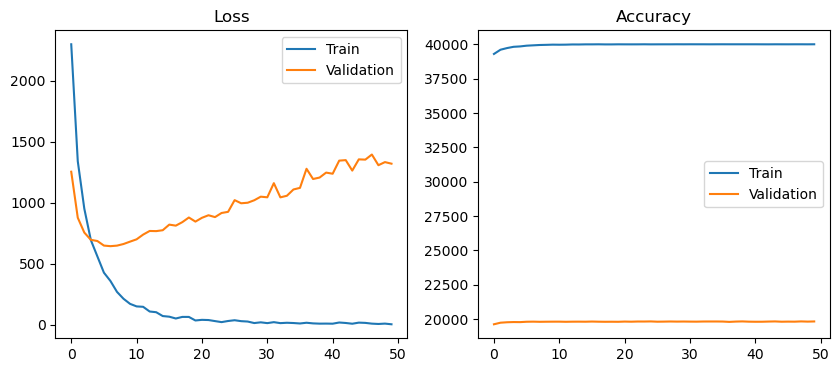

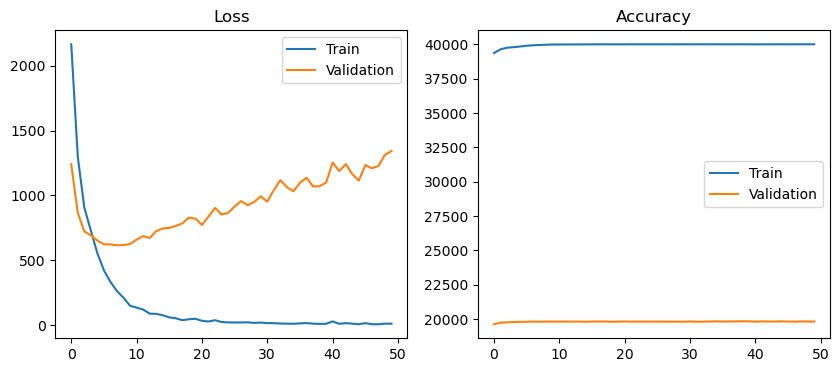

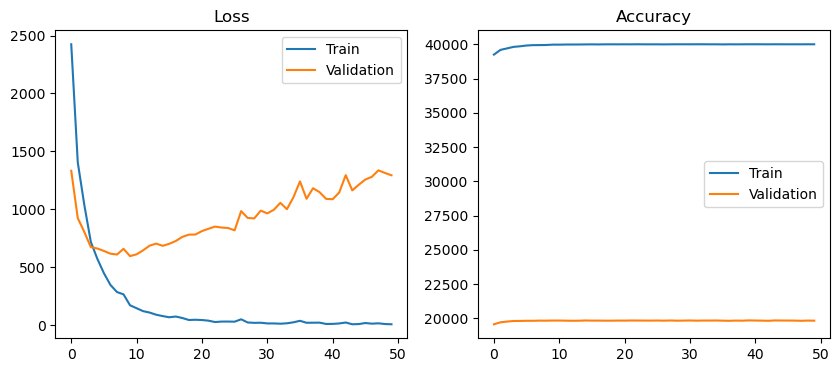

In [20]:
KFoldCrossValidation(Net50PCADropout, 3,X_train_pca, y_train, X_test_pca, y_test)

Fold 0:
Net50PCA - Number of parameters: 17110


func:train took: 40.4235 sec
Training accuracy: 39962.0
Test accuracy: 9920.0
Fold 1:
Net50PCA - Number of parameters: 17110


func:train took: 40.1917 sec
Training accuracy: 39952.0
Test accuracy: 9924.0
Fold 2:
Net50PCA - Number of parameters: 17110


func:train took: 39.6181 sec
Training accuracy: 39948.0
Test accuracy: 9921.0
Final results:
Training accuracy: 39954.0+/-5.887840577551898
Test accuracy: 9921.666666666666+/-1.699673171197595


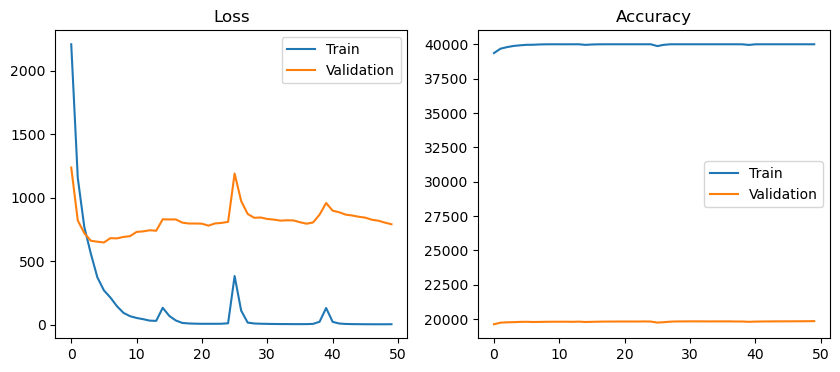

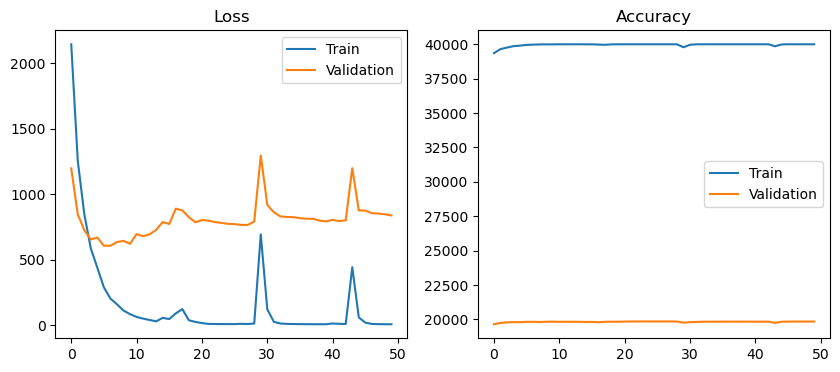

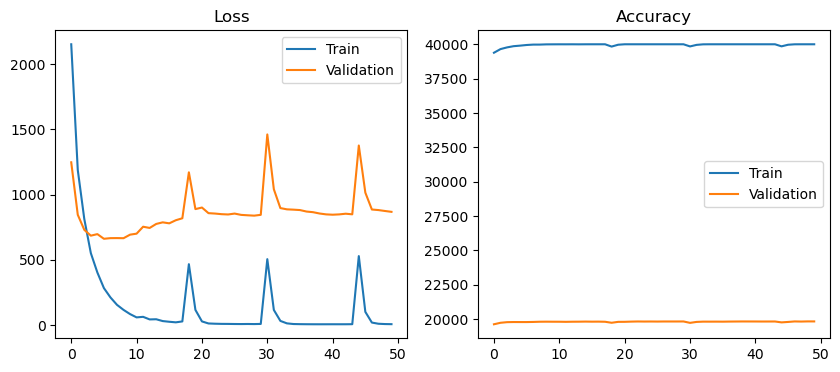

In [21]:
KFoldCrossValidation(Net50PCA, 3,X_train_pca, y_train, X_test_pca, y_test, l2 = 1e-5)

L2 regularization technique gives out better test accuracy.
Training time was slower in both regularization techniques compared to training without regularization